# Proximal Policy Optimization - CartPole

For PPO, the expections to maximize is:
$$ max_\theta E [ \frac{P(a|\pi_\theta(s))}{P(a|\pi_{\theta_{old}}(s))} A - \beta \cdot p]$$

where $\beta$ is the coefficient to weight the penalty $p$ and the penalty used here is kl divergence:

$$ p = KL(P(\cdot|\pi_{\theta_{old}}(s))) || P(\cdot|\pi_\theta(s)) $$

KL divergence measures the similarity of the distributions (0 being the same, and the larger the more different). So the first term in the expection will be regularized by this KL value. 

Finally, the KL divergence is defined as:

$$ KL(P(\cdot|\pi_{\theta_{old}}) || P(\cdot|\pi_\theta) = - \sum \left( P(\cdot|\pi_{\theta_{old}}) ln(\frac{P(\cdot|\pi_\theta)}{P(\cdot|\pi_{\theta_{old}})} \right) $$

For A2C, we optimize the critic and policy network separatly (however, we can optimize them together), here we optimize them together. So the loss function is then:

$$ loss = -\frac{P(a|\theta)}{P(a|\theta_{old})} A  - \beta \cdot KL(P(\theta)||P(\theta_{old})) + L_{value}$$

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from IPython.display import HTML
from cartpole_utils import env_cartpole, display_frames_as_gif, goalAchieved, test_cartpole

In [2]:
# networks

class ValueNet(nn.Module):
    def __init__(self):
        super(ValueNet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)
    
class ActorNet(nn.Module):
    def __init__(self):
        super(ActorNet, self).__init__()
        self.fc1 = nn.Linear(4, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        out = torch.relu(self.fc1(x))
        logits = self.fc2(out)
        return logits 

In [3]:
class ReplayMemory:
    def __init__(self):
        self.games = []

    def add(self, attrib:list):
        self.games.append(attrib)
        
    def __len__(self):
        return len(self.games)
    
    def clear(self):
        self.games.clear()
    
    def sample(self):
        out = []
        for i in range(len(self.games[0])):
            tensor = torch.tensor(np.array([items[i] for items in self.games]))
            out.append(tensor)
        return out

In [4]:
class PPOAgent:
    def __init__(self):
        self.value_net = ValueNet()
        self.actor_net = ActorNet()
        self.optim = torch.optim.AdamW(list(self.value_net.parameters())+list(self.actor_net.parameters()), lr=0.001)

    def act(self, state, train=True):
        if isinstance(state, np.ndarray):
            if len(state.shape) == 1:
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
            else:
                state = torch.tensor(state, dtype=torch.float32)
        with torch.no_grad():
            logit = self.actor_net(state)
            prob = F.softmax(logit, dim=-1)
            action = torch.multinomial(prob, 1).squeeze(0).detach()
            logprob_a = -F.cross_entropy(logit, action, reduction='none').detach()
        if train:
            return action.item(), logit, logprob_a.item()
        return action.item()
    
    def learn(self, plays):
        def cum_reward(rewards, gamma=0.99):
            cum_rewards = torch.zeros_like(rewards).to(torch.float32)
            for j in range(len(rewards))[::-1]:
                cum_rewards[j] = rewards[j] + gamma * (cum_rewards[j+1] if j+1<len(rewards) else 0)
            eps = np.finfo(np.float32).eps.item()
            cum_rewards = (cum_rewards - cum_rewards.mean()) / (cum_rewards.std() + eps)
            return cum_rewards.unsqueeze(-1)
        
        kl_coef = 10.0
        v_coef = 10.0

        # get data
        samples = plays.sample()
        
        # get samples batch
        states, rewards, actions, old_logits, old_logprobs_a, _ = samples

        # compute cumulated reward
        rewards_cum = cum_reward(rewards)

        new_values = self.value_net(states)
        new_logits = self.actor_net(states)

        advantages = rewards_cum - new_values

        new_logprobs_a = -F.cross_entropy(new_logits, actions, reduction='none').unsqueeze(-1)

        log_ratio = new_logprobs_a - old_logprobs_a
        prob_ratio = log_ratio.exp()

        kl = F.kl_div(new_logprobs_a, old_logprobs_a.exp(), reduction='none')

        vloss = F.mse_loss(new_values, rewards_cum, reduction='none')
        

        loss = -advantages * prob_ratio + kl * kl_coef + vloss * v_coef
        loss = loss.sum()
        # print((-advantages * prob_ratio.detach()).sum(), kl.sum().detach(), vloss.sum().detach())

        self.optim.zero_grad()
        loss.backward()
        self.optim.step()

        return loss.detach().item()

In [5]:
# train loop

epochs = 1000
state_num = 4 # 
action_num = 2
memory = ReplayMemory()
agent = PPOAgent()

scores = []
losses = []

for e in range(epochs):
    # reset environment
    state, _ = env_cartpole.reset()

    currState = state
    done = False

    score = 0
    tot_loss = 0
    count = 0

    # run an episode
    while not done :
        
        # choose action
        action, logit, logprob = agent.act(state)

        # take action on env
        state, reward, done, info, _ = env_cartpole.step(action)
        
        # add to replay memory
        memory.add([currState, reward, action, logit, logprob, done])

        currState = state.copy()

        # update score
        score += 1

        if score > 800:
            break
    
    # train
    loss = agent.learn(memory)

    # clear memory
    memory.clear()
    
    scores = np.append(scores, score)
    losses = np.append(losses, loss)

    if (e+1)%100 == 0:
        print(f"epoche: {e+1}, score: {score}, loss: {loss:.6f}")
    if goalAchieved(scores):
        break

epoche: 100, score: 32, loss: 7853.049345
epoche: 200, score: 42, loss: 16134.896706
epoche: 300, score: 138, loss: 109458.161574
epoche: 400, score: 87, loss: 66362.934865
epoche: 500, score: 53, loss: 30427.828918
epoche: 600, score: 161, loss: 182575.229451


In [6]:
frames = test_cartpole(env_cartpole, 300, agent=agent)
anim = display_frames_as_gif(frames)
HTML(anim.to_jshtml())

/home/niuniu/Documents/RL/env_rl/lib64/python3.13/site-packages/gymnasium/envs/classic_control/cartpole.py:214: UserWarning: WARN: You are calling 'step()' even though this environment has already returned terminated = True. You should always call 'reset()' once you receive 'terminated = True' -- any further steps are undefined behavior.
  logger.warn(


248


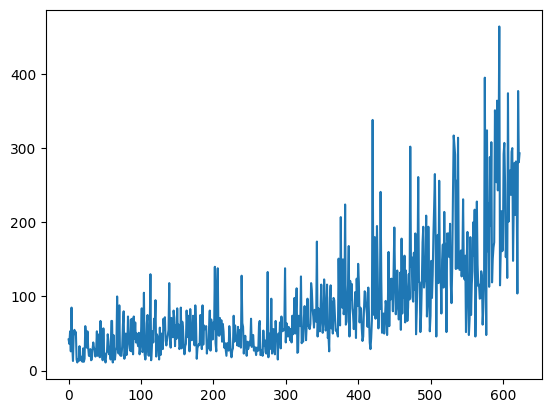

In [7]:
plt.plot(scores)

# docs

 - https://arxiv.org/pdf/1707.06347